[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-opendap/1-data-cube-opendap.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link]

[download-link]: https://nmfs-opensci.github.io/NMFSHackDays-2025/topics-2025/2025-opendap/1-data-cube-opendap.ipynb
[colab-link]: https://colab.research.google.com/github/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-opendap/1-data-cube-opendap.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/nmfs-opensci/nmfshackdays-2025/main/topics-2025/2025-opendap/1-data-cube-opendap.ipynb

>📘 Learning Objectives
>
> 1. Create a data cube using links to files on THREDDS and OPeNDAP servers
> 2. Do some basic data aggregation.

## Overview

THREDDS is a common type of data server that usually includes multiple ways to access the data. One of those ways is via the OPeNDAP protocol which allows you to subset the data, instead of downloading the whole data file. Here you will learn to use `xarray`'s `open_mfdataset` to create data cubes on THREDDS servers using the OPeNDAP protocol.

## NCEP-NCAR Reanalysis 1

For our first example, we will use 4xDaily Air temperature at sigma level 995 data (`air.sig995`) from the [NCEP-NCAR Reanalysis 1](NCEP-NCAR Reanalysis 1). First look at the [THREDDS catalog](https://psl.noaa.gov/thredds/catalog/Datasets/ncep.reanalysis/surface/catalog.html) to orient yourself to the file naming convention. We can click on one of the files an see our [access options]. We are looking for the OPeNDAP information as we need to get the url for that. Clicking the [OPeNDAP link](https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1948.nc.html) reveals the url format of the files:
```
https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995.1948.nc
```

Now we can create the file urls.

In [1]:
base_url = 'http://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis/surface/air.sig995'

files = [f'{base_url}.{year}.nc' for year in range(1948, 2025)]
len(files)

77

We will load the file metadata with `open_mfdataset` and create our virtual data cube. It will take 30 seconds or so but it doesn't use much memory as we are only reading and loading the file metadata.

In [2]:
%%time
import xarray as xr
ds = xr.open_mfdataset(files);

CPU times: user 2.73 s, sys: 368 ms, total: 3.09 s
Wall time: 25.3 s


In [6]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 112500, lat: 73, lon: 144)
Coordinates:
  * lon      (lon) float32 576B 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 900kB 1948-01-01 ... 2024-12-31T18:00:00
  * lat      (lat) float32 292B 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
Data variables:
    air      (time, lat, lon) float32 5GB dask.array<chunksize=(1464, 73, 144), meta=np.ndarray>
Attributes:
    Conventions:                     COARDS
    title:                           4x daily NMC reanalysis (1948)
    description:                     Data is from NMC initialized reanalysis\...
    platform:                        Model
    history:                         created 99/05/11 by Hoop (netCDF2.3)\nCo...
    dataset_title:                   NCEP-NCAR Reanalysis 1
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    DODS_EXTRA.Unlimited_Dimension:  time

The data set is not that huge.

In [7]:
print(f"{ds.nbytes / 1e9} Gb")

4.731300868 Gb


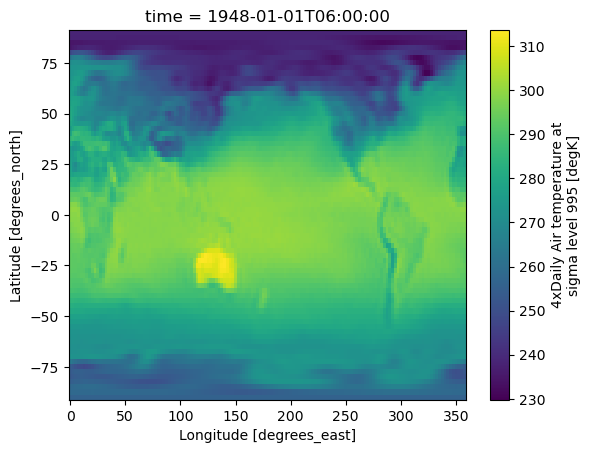

In [9]:
ds['air'].isel(time=1).plot()

## Creating daily means

For one year, we can create a daily mean since 1 year is not that much data and we can fit that into memory.

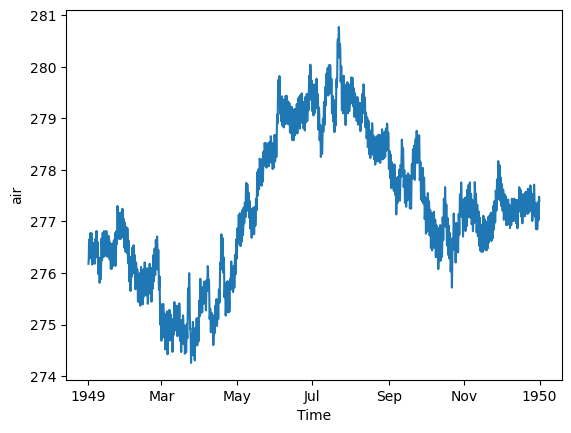

In [17]:
ds_mean = ds["air"].sel(time="1949").mean(dim=['lat', 'lon'])
ds_mean.plot();

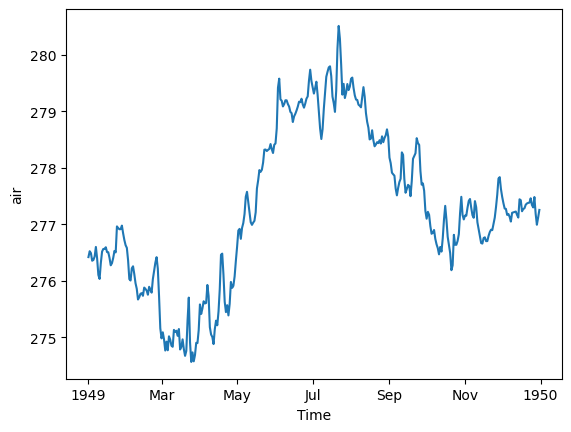

In [18]:
# resample to daily
ds_mean.resample(time='D').mean().plot();

But if we try to do all years at once, we will run out of memory and it is possible that the THREDDS server will complain that we are making too big of a data request. So let's tackle this problem by chunking up the data.

### Chunking the data

I choose chunking to get to about 100 Mb sized chunks.

In [4]:
import dask
ds_chunk = ds["air"].sel(lat=slice(25,-25), lon=slice(-25,25)).chunk({'time': 1464, 'lat': -1, 'lon': -1})
ds_chunk

<xarray.DataArray 'air' (time: 112500, lat: 21, lon: 11)> Size: 104MB
dask.array<rechunk-merge, shape=(112500, 21, 11), dtype=float32, chunksize=(1464, 21, 11), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 44B 0.0 2.5 5.0 7.5 10.0 ... 15.0 17.5 20.0 22.5 25.0
  * time     (time) datetime64[ns] 900kB 1948-01-01 ... 2024-12-31T18:00:00
  * lat      (lat) float32 84B 25.0 22.5 20.0 17.5 ... -17.5 -20.0 -22.5 -25.0
Attributes: (12/13)
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    ...            ...
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]
    valid_range:   [185.16 331.16]
    dataset:       NCEP Reanalysis
    level_desc:    0.995 sigma
    _ChunkSizes:   [  1  73 144]

In [4]:
mean_all_years = ds_chunk.sel(time=slice("1948", "1958")).mean(dim=['lat', 'lon'])
mean_all_years

<xarray.DataArray 'air' (time: 16072)> Size: 64kB
dask.array<mean_agg-aggregate, shape=(16072,), dtype=float32, chunksize=(1464,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 129kB 1948-01-01 ... 1958-12-31T18:00:00

In [5]:
# This is takes about 4 minutes; 1.56
from dask.diagnostics import ProgressBar

with ProgressBar():
    mean_all_years = ds_chunk.sel(time=slice("1948", "1958")).mean(dim=['lat', 'lon']).compute()

[########################################] | 100% Completed | 51.77 s


In [5]:
mean_all_years.compute()

<xarray.DataArray 'air' (time: 16072)> Size: 64kB
array([276.0041 , 276.12732, 276.54147, ..., 275.8719 , 276.2409 ,
       276.08835], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 129kB 1948-01-01 ... 1958-12-31T18:00:00

In [5]:
# This is takes about 4 minutes; 1.56
from dask.diagnostics import ProgressBar

with ProgressBar():
    mean_all_years.compute()

[########################################] | 100% Completed | 203.47 s


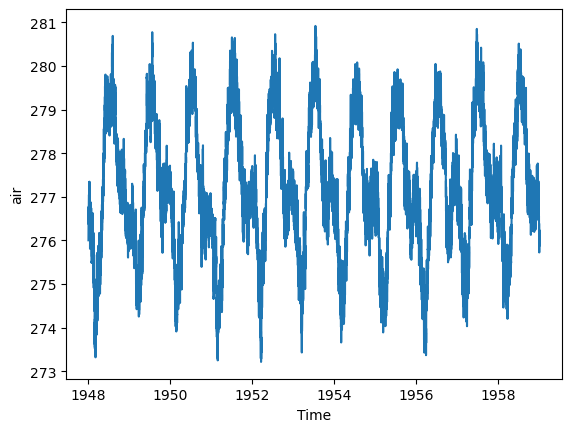

In [7]:
mean_all_years.plot();

In [4]:
ds_mean = ds["air"].sel(time=slice("1948", "1958")).mean(dim=['lat', 'lon']).compute()

In [5]:
ds_mean

<xarray.DataArray 'air' (time: 16072)> Size: 64kB
dask.array<mean_agg-aggregate, shape=(16072,), dtype=float32, chunksize=(1464,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 129kB 1948-01-01 ... 1958-12-31T18:00:00

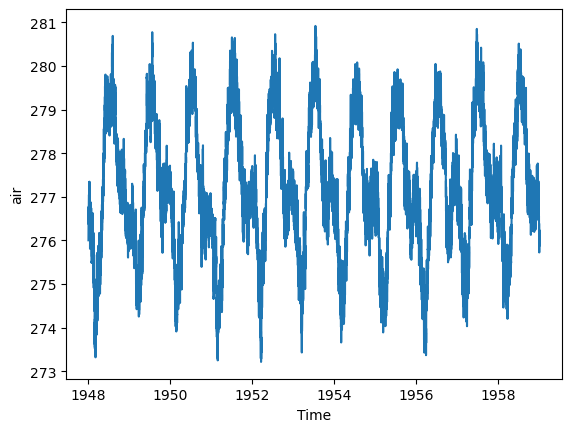

In [6]:
ds_mean.plot();

In [3]:
# takes 4 minutes; 1.5 Gb
from dask.diagnostics import ProgressBar

with ProgressBar():
    mean_ds = ds.sel(time=slice("1948", "1958")).mean(dim=['lat', 'lon']).persist()

[########################################] | 100% Completed | 231.80 s


In [5]:
ds["air"].encoding["chunksizes"]

KeyError: 'chunksizes'

In [6]:
print(ds["air"].chunks)

((1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464, 1460, 1460, 1460, 1464), (73,), (144,))


In [9]:
mean_all_years = ds_chunk.sel(time=slice("1948", "1958")).mean(dim=['lat', 'lon'])
mean_all_years.data.visualize()

RuntimeError: No visualization engine detected, please install graphviz or ipycytoscape

In [14]:
ds_chunk.mean(dim=['lat', 'lon'])

<xarray.DataArray 'air' (time: 112500)> Size: 450kB
dask.array<mean_agg-aggregate, shape=(112500,), dtype=float32, chunksize=(1464,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 900kB 1948-01-01 ... 2024-12-31T18:00:00

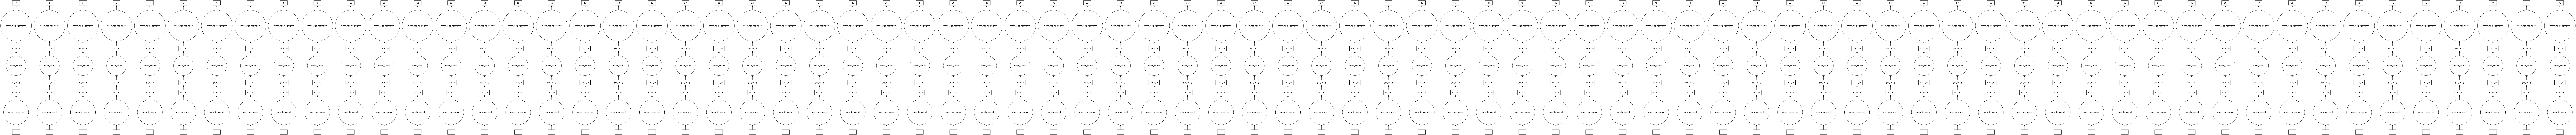

In [24]:
dask.visualize(ds.mean(dim=['lat', 'lon']))

In [17]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
from dask.distributed import Client
client = Client()  # Starts a local Dask cluster
ds_chunk = ds.chunk({'time': 1000, 'lat': 25, 'lon': -1})
mean_all_years = ds_chunk.sel(time=slice("1948", "1958")).mean(dim=['lat', 'lon']).compute()

2025-03-14 17:05:43,952 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 292.64 MiB -- Worker memory limit: 474.75 MiB
2025-03-14 17:06:07,393 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 296.00 MiB -- Worker memory limit: 474.75 MiB
2025-03-14 17:06:07,528 - distributed.worker.memory - WARNING - Worker is at 87% memory usage. Pausing worker.  Process memory: 415.69 MiB -- Worker memory limit: 474.75 MiB
2025-03-14 17:06:07,629 - distributed.worker.memory - WARNING - Worker is at 74% memory usage. Resuming worker. 

KilledWorker: Attempted to run task ('rechunk-split-efe00704571913867602840a1828e0a4', 19) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:38721. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [4]:
client.close()

2025-03-14 17:08:26,324 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/utils_comm.py", line 441, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/utils_comm.py", line 420, in re

In [5]:
mean_all_years

NameError: name 'mean_all_years' is not defined

In [8]:
from pympler import muppy, summary

all_objects = muppy.get_objects()
summary.print_(summary.summarize(all_objects))

                                        types |   # objects |   total size
============================================= | =========== | ============
                                          str |      136046 |     22.66 MB
                                         code |       51246 |     19.58 MB
                                         dict |       47311 |     14.23 MB
                                         type |        6829 |      8.27 MB
  pandas.core.indexes.datetimes.DatetimeIndex |           2 |      5.01 MB
            pandas._libs.index.DatetimeEngine |           2 |      4.03 MB
                                        tuple |       54950 |      3.43 MB
                                         list |       18366 |      1.61 MB
                                  abc.ABCMeta |         715 |      1.09 MB
                                          set |        2189 |      1.02 MB
                                numpy.ndarray |          91 |    951.98 KB
                         

In [7]:
pip install pympler

Note: you may need to restart the kernel to use updated packages.


In [10]:
def compute_mean(subset):
    return subset.mean(dim=['lat', 'lon'])

ds_chunk = ds.chunk({'time': 365, 'lat': 25, 'lon': 50})  # Chunk by year

# Apply function to each year
yearly_means = ds_chunk.groupby("time.year").map(compute_mean)

# Compute results
yearly_means = yearly_means.compute()


KeyboardInterrupt: 

In [3]:
import xarray as xr
import gc

# Open dataset with explicit chunking
ds_chunk = ds.chunk({'time': 365, 'lat': 25, 'lon': 50})  # One year per chunk

# Process year by year
mean_results = []
for year in range(1948, 1959):  # Process one year at a time
    print(f"Processing year {year}")
    ds_year = ds_chunk.sel(time=str(year))
    yearly_mean = ds_year.mean(dim=['lat', 'lon']).compute()
    
    mean_results.append(yearly_mean)  # Store only computed value
    
    # Release memory
    del yearly_mean
    del ds_year
    gc.collect()

# Combine results (optional)
final_mean = xr.concat(mean_results, dim="time")

# Cleanup
del ds_chunk, mean_results
gc.collect()


Processing year 1948
Processing year 1949
Processing year 1950
Processing year 1951
Processing year 1952
Processing year 1953
Processing year 1954
Processing year 1955
Processing year 1956
Processing year 1957
Processing year 1958


0

In [3]:
import xarray as xr
import gc

# Process year by year
mean_results = []
for year in range(1948, 1959):  # Process one year at a time
    print(f"Processing year {year}")
    ds_year = ds.sel(time=str(year)).load()
    yearly_mean = ds_year.mean(dim=['lat', 'lon']).compute()
    
    mean_results.append(yearly_mean)  # Store only computed value
    
    # Release memory
    del yearly_mean
    del ds_year
    gc.collect()

# Combine results (optional)
final_mean = xr.concat(mean_results, dim="time")

# Cleanup
del mean_results
gc.collect()

Processing year 1948
Processing year 1949
Processing year 1950
Processing year 1951
Processing year 1952
Processing year 1953
Processing year 1954
Processing year 1955
Processing year 1956
Processing year 1957
Processing year 1958


NameError: name 'ds_chunk' is not defined

In [ ]:
ds.load()